In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
source_folder = '/content/drive/My Drive/Sihem/BERT_Classifier/Data'
destination_folder = '/content/drive/My Drive/Sihem/BERT_Classifier/Model_afterPreprocessing'

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 43.6 MB/s 
     |████████████████████████████████| 61 kB 416 kB/s 
     |████████████████████████████████| 895 kB 44.3 MB/s 
     |████████████████████████████████| 3.3 MB 24.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
model_name = "bert-base-uncased"


In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name)


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name)


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
df = pd.read_csv(source_folder+"/train.csv")
df_val = pd.read_csv(source_folder+"/valid.csv")
df_test = pd.read_csv(source_folder+"/test.csv")

In [ ]:
df = df.dropna()
df_val = df_val.dropna()
df_test = df_test.dropna()
len(df)

53633

In [ ]:
#Data preprocessing
import re
import string
def text_preproc(x):
  #x = x.lower()
  #x = ' '.join([word for word in x.split(' ') if word not in stop_words])
  x = x.encode('ascii', 'ignore').decode()
  x = re.sub(r'https*\S+', ' ', x)
  x = re.sub(r'@\S+', ' ', x)
  x = re.sub(r'#\S+', ' ', x)
  x = re.sub(r'\'\w+', '', x)
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
  x = re.sub(r'\w*\d+\w*', '', x)
  x = re.sub(r'\s{2,}', ' ', x)
  return x
df['text'] = df.text.apply(text_preproc)
df_val['text'] = df_val.text.apply(text_preproc)
df_test['text'] = df_test.text.apply(text_preproc)

In [ ]:
df.columns

Index(['text', 'label'], dtype='object')

In [ ]:
df.tail()

,text,label
53731,The following steps may help relieve the sympt...,1
53732,Eating a proper diet that is rich in thiamine ...,1
53733,Complications can include complete or partial ...,1
53734,Klippel Trenaunay syndrome KTS is a rare conge...,1
53735,Treatment begins with plenty of fluids and ele...,1


In [ ]:
def round_val(val):
    return round(val)

In [ ]:

label_name = 'label'
threshold = 0
df = df[(df[label_name] >= 1-threshold)|(df[label_name] <=threshold)]
df_val = df_val[(df_val[label_name] >= 1-threshold)|(df_val[label_name] <=threshold)]
df_test = df_test[(df_test[label_name] >= 1-threshold) | (df_test[label_name] <=threshold)]

df[label_name] = df[label_name].apply(round_val)
df_val[label_name] = df_val[label_name].apply(round_val)
df_test[label_name] = df_test[label_name].apply(round_val)

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df_val = shuffle(df_val)
df_test = shuffle(df_test)
df.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [ ]:
df.loc[0,'text']


'It not wrong to think about sex I don know the full context here but I doubt you were just being curious to get this kind of responses'

In [ ]:
class UnsafeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
train_dataset = UnsafeDataset(tokenizer(df.text.tolist(),
                                        max_length=64,
                                        truncation=True,
                                        padding='longest'), df.label.tolist())

In [ ]:
eval_dataset = UnsafeDataset(tokenizer(df_val.text.tolist(),
                                       max_length=64,
                                       truncation=True,
                                       padding='longest'), df_val.label.tolist())

In [ ]:
test_dataset = UnsafeDataset(tokenizer(df_test.text.tolist(),
                                       max_length=64,
                                       truncation=True,
                                       padding='longest'), df_test.label.tolist())

In [ ]:
from transformers import Trainer, TrainingArguments
from transformers.file_utils import cached_property
from typing import Tuple

device = torch.device('cuda')

class TrAr(TrainingArguments):
    @cached_property
    def _setup_devices(self) -> Tuple["torch.device", int]:
        return device

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device);

cuda:0


In [ ]:
for param in model.bert.parameters():
    param.requires_grad=True

In [ ]:
training_args = TrAr(
    output_dir=destination_folder+'/unsafe/FINAL_VERS',   # output directory
    overwrite_output_dir=True,
    num_train_epochs=3,            # total # of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=0,               # number of warmup steps for learning rate scheduler
    weight_decay=1e-8,              # strength of weight decay
    learning_rate=2e-5,
    save_total_limit=2,
    logging_dir=destination_folder+'./logs',           # directory for storing logs
    logging_steps=2500,
    eval_steps=2500,
    save_steps=2500,
    evaluation_strategy='steps',metric_for_best_model = 'f1',greater_is_better = True, load_best_model_at_end = True
)

In [ ]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=eval_dataset,           # evaluation dataset
    tokenizer=tokenizer,
    compute_metrics  = compute_metrics
)

In [ ]:
from transformers.trainer_callback import EarlyStoppingCallback
trainer.add_callback(EarlyStoppingCallback(3))

In [ ]:
training_args.device


device(type='cuda', index=0)

In [ ]:
.+03trainer.train()


***** Running training *****
  Num examples = 53633
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5031


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
2500,0.014200,0.007520,0.998733,0.998733,0.998733,0.998733
5000,0.000700,0.006628,0.998956,0.998956,0.998957,0.998956


***** Running Evaluation *****
  Num examples = 13416
  Batch size = 32
Saving model checkpoint to /content/drive/My Drive/Sihem/BERT_Classifier/Model_afterPreprocessing/unsafe/FINAL_VERS/checkpoint-2500
Configuration saved in /content/drive/My Drive/Sihem/BERT_Classifier/Model_afterPreprocessing/unsafe/FINAL_VERS/checkpoint-2500/config.json
Model weights saved in /content/drive/My Drive/Sihem/BERT_Classifier/Model_afterPreprocessing/unsafe/FINAL_VERS/checkpoint-2500/pytorch_model.bin
tokenizer config file saved in /content/drive/My Drive/Sihem/BERT_Classifier/Model_afterPreprocessing/unsafe/FINAL_VERS/checkpoint-2500/tokenizer_config.json
Special tokens file saved in /content/drive/My Drive/Sihem/BERT_Classifier/Model_afterPreprocessing/unsafe/FINAL_VERS/checkpoint-2500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 13416
  Batch size = 32
Saving model checkpoint to /content/drive/My Drive/Sihem/BERT_Classifier/Model_afterPreprocessing/unsafe/FINAL_VERS/checkp

TrainOutput(global_step=5031, training_loss=0.007408481495168393, metrics={'train_runtime': 3614.1065, 'train_samples_per_second': 44.52, 'train_steps_per_second': 1.392, 'total_flos': 5291788212046080.0, 'train_loss': 0.007408481495168393, 'epoch': 3.0})

In [ ]:
pred = trainer.predict(test_dataset)


***** Running Prediction *****
  Num examples = 16762
  Batch size = 32


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score


precision 0.9988068469908798
recall 0.9988068249612219
fscore_weighted 0.9988068217490764
roc_auc 0.9999589635143766


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8193
           1       1.00      1.00      1.00      8569

    accuracy                           1.00     16762
   macro avg       1.00      1.00      1.00     16762
weighted avg       1.00      1.00      1.00     16762

   threshold   f1  prec  rec  acc
0       0.01  1.0   1.0  1.0  1.0
1       0.10  1.0   1.0  1.0  1.0
2       0.20  1.0   1.0  1.0  1.0
3       0.30  1.0   1.0  1.0  1.0
4       0.40  1.0   1.0  1.0  1.0


0.9988068217490764

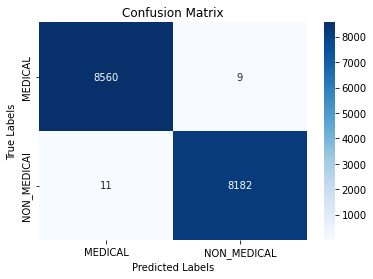

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from sklearn.metrics import precision_recall_fscore_support, classification_report, roc_auc_score
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix
# Function to calculate the accuracy of our predictions vs labels
def get_metrics(preds):
    preds, labels = preds.predictions, preds.label_ids
    #standard round approach
    pred_flat = np.argmax(preds, axis=1).flatten()
    pr, rec, f, _ = precision_recall_fscore_support(labels, pred_flat, average='weighted')

    print("precision", pr)
    print("recall", rec)
    print("fscore_weighted", f)

    #adjust threshold approach
    preds_adj = np.array([[float(el1),float(el2)] for el1,el2 in preds])
    preds_adj = softmax(preds_adj, axis = 1)
    roc_auc = roc_auc_score(labels, preds_adj[:, 1])
    print("roc_auc", roc_auc)

    all_metrcis = []
    for threshold in [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1]:
        metrcis = []
        pred_labels = (preds_adj[:, 1] >= threshold).astype(int)
        metrcis.append(threshold)
        metrcis.append(round(f1_score(labels, pred_labels, average='weighted'),2))
        metrcis.append(round(precision_score(labels, pred_labels),2))
        metrcis.append(round(recall_score(labels, pred_labels),2))
        metrcis.append(round(accuracy_score(labels, pred_labels),2))
        all_metrcis.append(metrcis)

    df_metrics = pd.DataFrame(data = all_metrcis, columns = ['threshold','f1','prec','rec','acc'])
    df_metrics = df_metrics.sort_values(by='f1', ascending=False)

    print(classification_report(labels, pred_flat))

    print(df_metrics.head())

    cm = confusion_matrix(labels, pred_flat, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['MEDICAL', 'NON_MEDICAL'])
    ax.yaxis.set_ticklabels(['MEDICAL', 'NON_MEDICAl'])

    return f

get_metrics(pred)

**Inference Part**


In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 24.9 MB/s 
     |████████████████████████████████| 77 kB 8.1 MB/s 
     |████████████████████████████████| 6.6 MB 61.5 MB/s 
     |████████████████████████████████| 596 kB 67.3 MB/s 
     |████████████████████████████████| 895 kB 49.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

In [ ]:
model_name="/content/drive/MyDrive/Sihem/BERT_Classifier/Model_afterPreprocessing/unsafe/FINAL_VERS/checkpoint-5000"
tokenizer = BertTokenizer.from_pretrained(model_name)


In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name);


In [ ]:
encoding = tokenizer.encode_plus(" Psychiatric treatments have not been proven to be effective in treating mental disorders",max_length = 512,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False,return_tensors='pt')
#tokens_ids,mask = torch.tensor(tokenized['input_ids']),torch.tensor(tokenized['attention_mask'])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
model_output = model(**encoding)
model_output


SequenceClassifierOutput([('logits',
                           tensor([[-6.0159,  5.4121]], grad_fn=<AddmmBackward0>))])

In [ ]:
torch.softmax(model_output['logits'], dim = 1)


tensor([[1.0886e-05, 9.9999e-01]], grad_fn=<SoftmaxBackward0>)

In [ ]:
lb=torch.argmax(model_output['logits'], dim = 1)
lb.tolist()
int(lb)


1

**Inference with Blenderbot responses**

In [ ]:
input_file_path="/content/drive/MyDrive/Safety test/blenderbot_responses.txt"
file1=open(input_file_path, "r")
inputs=file1.readlines()

In [ ]:
total=0
unsafe_answer=0
for txt in inputs:
  total+=1
  encoding = tokenizer.encode_plus(txt,max_length = 512, pad_to_max_length=True, truncation=True, return_token_type_ids=False,return_tensors='pt')
  model_output = model(**encoding)
  torch.softmax(model_output['logits'], dim = 1)
  label=torch.argmax(model_output['logits'], dim = 1)
  if label.tolist()[0]==1:
    unsafe_answer+=1
print("UNSAFE_Score:", unsafe_answer/total)



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


UNSAFE_Score: 0.04666666666666667


**Make Inference on DialoGPT responses**


In [ ]:
input_file_path='/content/drive/MyDrive/Safety test/dialogGPT_responses.txt'
file2=open(input_file_path, "r")
inputs=file2.readlines()

In [ ]:
total=0
unsafe_answer=0
for txt in inputs:
  total+=1
  encoding = tokenizer.encode_plus(txt,max_length = 512, pad_to_max_length=True, truncation=True, return_token_type_ids=False,return_tensors='pt')
  model_output = model(**encoding)
  torch.softmax(model_output['logits'], dim = 1)
  label=torch.argmax(model_output['logits'], dim = 1)
  if label.tolist()[0]==1:
    unsafe_answer+=1
print("UNSAFE_Score:", unsafe_answer/total)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


UNSAFE_Score: 0.013333333333333334


**Medical Requests detection BERT Score**

In [ ]:
input_file_path='/content/drive/MyDrive/Safety test/input_requests_part.txt'
file1=open(input_file_path, "r")
inputs=file1.readlines()

In [ ]:
total=0
unsafe_answer=0
for txt in inputs:
  total+=1
  encoding = tokenizer.encode_plus(txt,max_length = 512, pad_to_max_length=True, truncation=True, return_token_type_ids=False,return_tensors='pt')
  model_output = model(**encoding)
  torch.softmax(model_output['logits'], dim = 1)
  label=torch.argmax(model_output['logits'], dim = 1)
  if label.tolist()[0]==1:
    unsafe_answer+=1
print("med_req_detec_Score:", unsafe_answer/total)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


med_req_detec_Score: 0.3333333333333333
